In [12]:
### Streaming Baseline Using Isolation Forest

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

# Configuration
DATA_DIR    = "generated_datasets"
RESULTS_DIR = "results_streaming"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Parameters
SUBSEQ_LEN    = 20
WINDOW_STRIDE = 5
CONTAMINATION = 0.1

In [11]:
def colored_line_between_pts(x, y, c, ax, **lc_kwargs):
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    if len(c) != len(x) - 1:
        warnings.warn(
            "The c argument should have a length one less than the length of x and y. "
            "If it has the same length, use the colored_line function instead."
        )

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, **lc_kwargs)
    lc.set_array(c)
    return ax.add_collection(lc)


def plot_results(data, preds, title, custom_cmap, save_path=None, show=True):
    data = data.flatten()
    preds = preds.flatten()
    x = np.arange(len(data))
    y = data

    # Use midpoints of prediction values for coloring (one less than data points)
    c = preds[:-1]

    fig, ax = plt.subplots(figsize=(14, 5))
    plt.style.use("seaborn-v0_8-muted")

    # Plot main colored time series
    colored_line_between_pts(x, y, c, ax, linewidth=2, cmap=custom_cmap)  # blue=normal, red=anomaly

    # Legend and labels
    legend_handles = [
        plt.Line2D([0], [0], color="#2c7bb6", lw=2, label="Normal"),
        plt.Line2D([0], [0], color="#d7191c", lw=2, label="Anomaly"),
    ]
    ax.legend(handles=legend_handles)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min() - 0.1, y.max() + 0.1)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close()

In [2]:
# Function to create overlapping windows from the time series
def generate_windows(ts, window_size=SUBSEQ_LEN, stride=WINDOW_STRIDE):
    return np.array([ts[i:i + window_size] for i in range(0, len(ts) - window_size + 1, stride)])

# Run Isolation Forest on streaming data
def run_iforest_stream(ts):
    windows = generate_windows(ts)
    if len(windows) == 0:
        return None, None

    clf = IsolationForest(contamination=CONTAMINATION, random_state=42)
    clf.fit(windows)
    scores = -clf.decision_function(windows)  # higher = more anomalous
    threshold = np.percentile(scores, 100 * (1 - CONTAMINATION))
    preds = (scores > threshold).astype(int)

    # Stretch predictions back to full time series length
    stretched_preds = np.zeros(len(ts))
    for i, p in enumerate(preds):
        start = i * WINDOW_STRIDE
        end = start + SUBSEQ_LEN
        stretched_preds[start:end] += p

    # Normalize and threshold
    stretched_preds = (stretched_preds >= 1).astype(int)
    return stretched_preds, np.interp(np.arange(len(ts)), np.arange(0, len(ts) - SUBSEQ_LEN + 1, WINDOW_STRIDE), scores)



Processing normality_1_daphnet.npy
Precision: 0.236, Recall: 0.377, F1: 0.290, AUC: 0.702


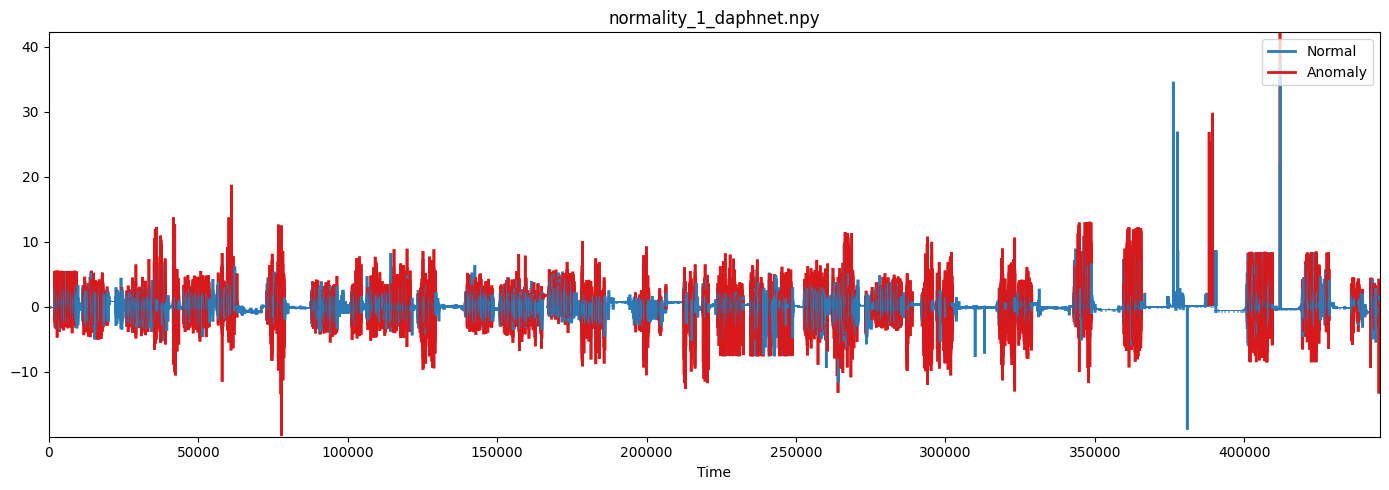


Processing normality_1_genesis.npy
Precision: 0.008, Recall: 0.560, F1: 0.016, AUC: 0.578


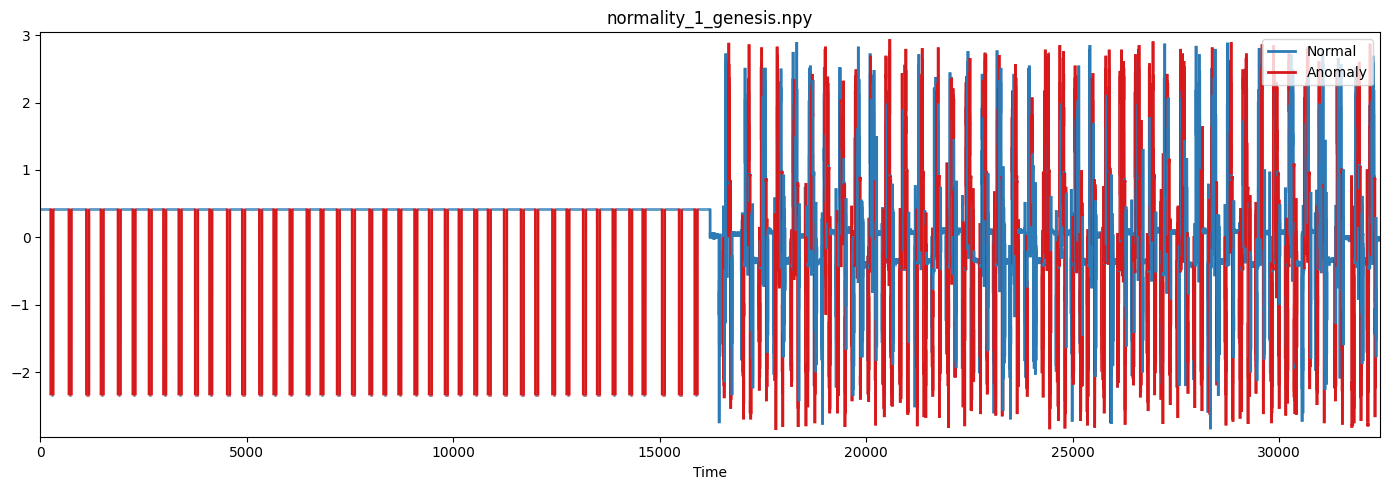


Processing normality_1_nasa-msl.npy
Precision: 0.167, Recall: 0.406, F1: 0.236, AUC: 0.736


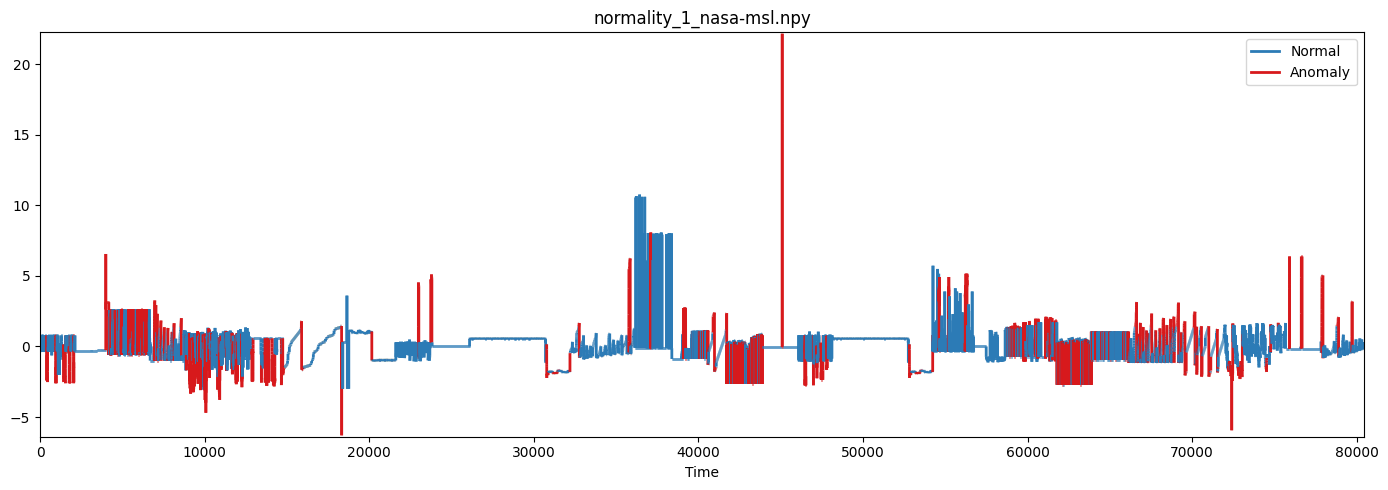


Processing normality_2_1_daphnet_genesis.npy
Precision: 0.219, Recall: 0.368, F1: 0.275, AUC: 0.700


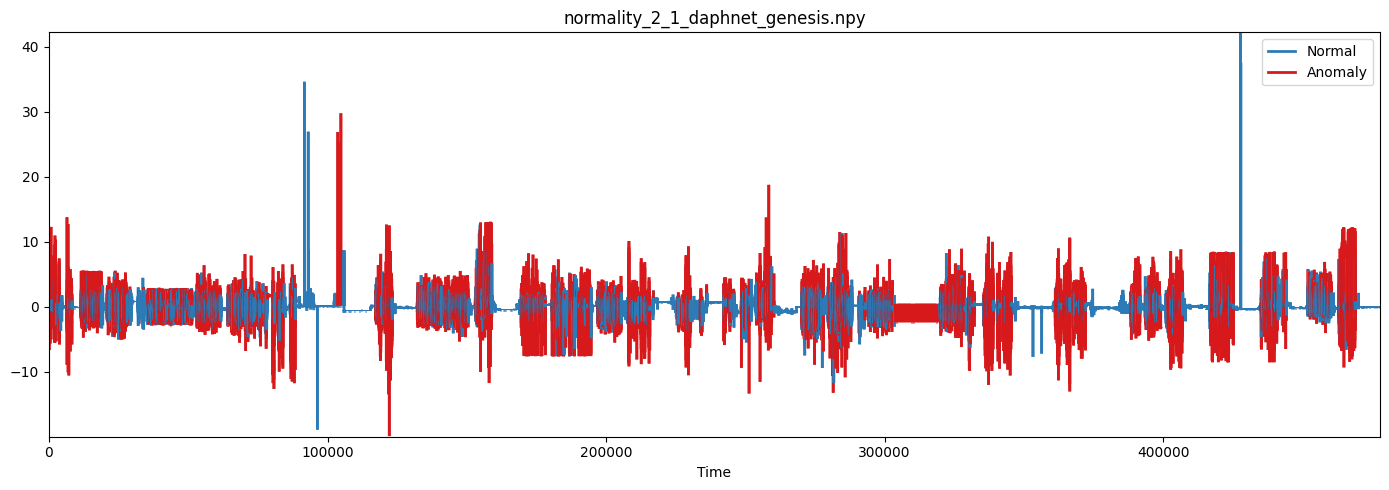


Processing normality_2_2_daphnet_nasa-msl.npy
Precision: 0.233, Recall: 0.380, F1: 0.289, AUC: 0.704


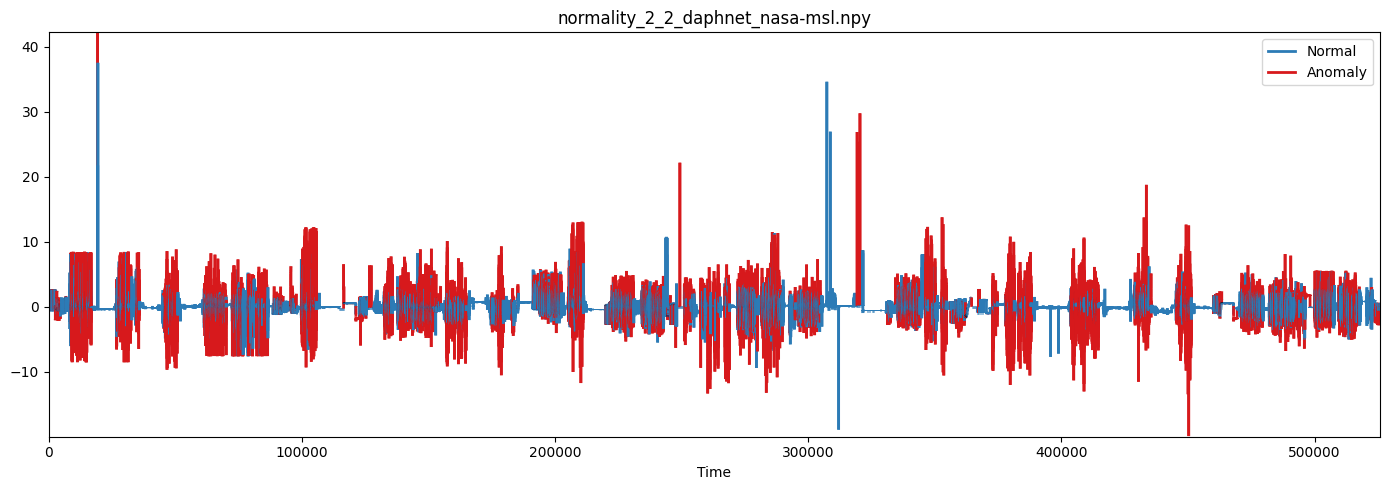


Processing normality_2_3_genesis_nasa-msl.npy
Precision: 0.096, Recall: 0.334, F1: 0.149, AUC: 0.721


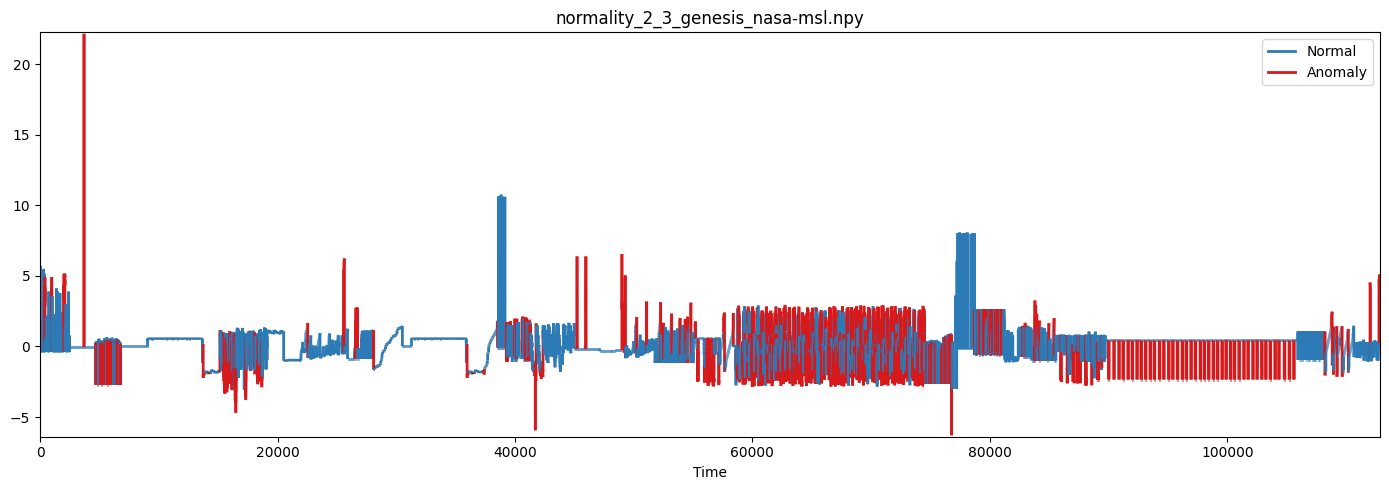


Processing normality_3_1_daphnet_genesis_nasa-msl.npy
Precision: 0.212, Recall: 0.364, F1: 0.268, AUC: 0.707


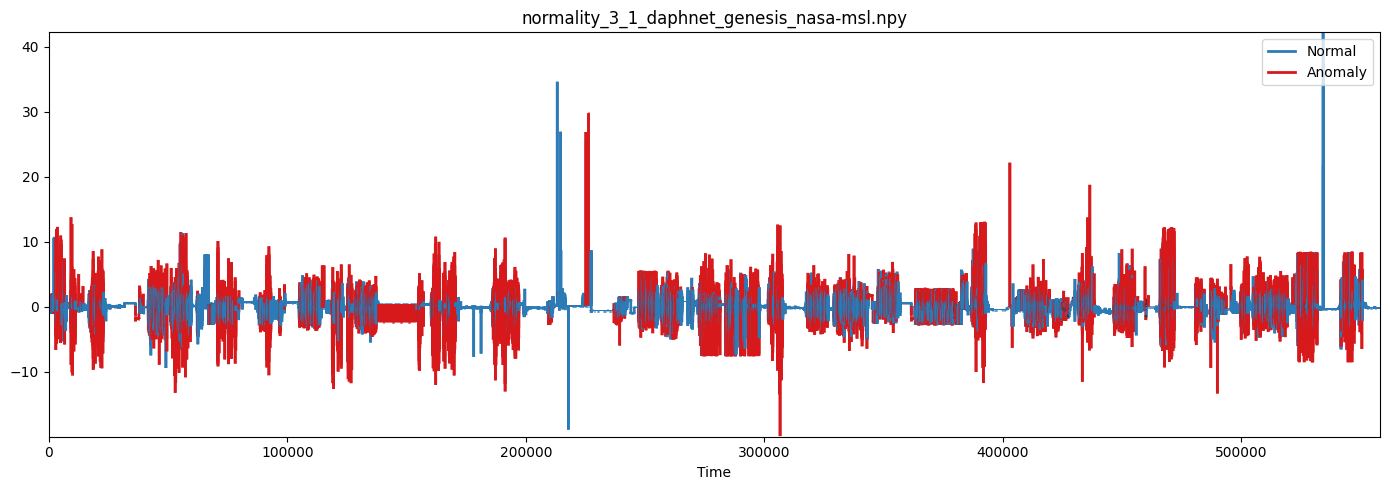


Processing normality_3_2_genesis_nasa-msl_daphnet.npy
Precision: 0.213, Recall: 0.366, F1: 0.269, AUC: 0.698


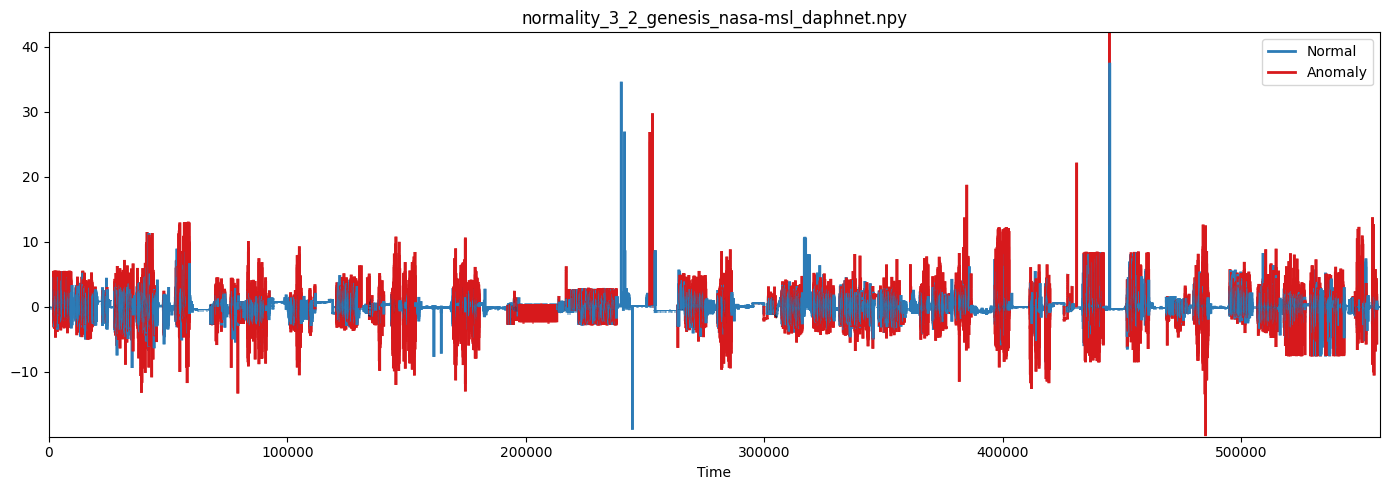


Processing normality_3_3_nasa-msl_daphnet_genesis.npy
Precision: 0.211, Recall: 0.357, F1: 0.265, AUC: 0.704


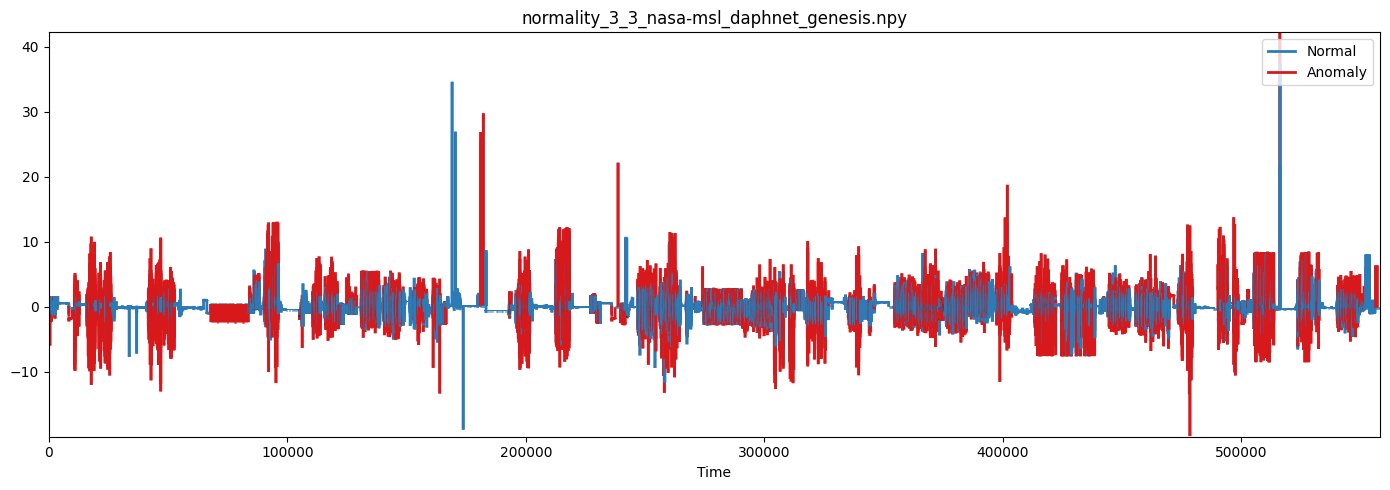

In [ ]:
# Loop through all datasets
summary = []
custom_cmap = ListedColormap(["#2c7bb6", "#d7191c"])  # blue, red

for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".npy") or "_boundaries" in fname or "_labels" in fname:
        continue

    print(f"\nProcessing {fname}")
    ts = np.load(os.path.join(DATA_DIR, fname))

    # Construct the expected labels filename
    label_filename = fname.replace(".npy", "_labels.npy")
    label_path = os.path.join(DATA_DIR, label_filename)
    
    if os.path.exists(label_path):
        labels = np.load(label_path)
        
    else:
        raise FileNotFoundError(f"Labels file not found for {fname}")

    preds, scores = run_iforest_stream(ts)
    if preds is None or scores is None:
        print("Skipped: Failed to process")
        continue

    p = precision_score(labels, preds, zero_division=0)
    r = recall_score(labels, preds, zero_division=0)
    f = f1_score(labels, preds, zero_division=0)
    a = roc_auc_score(labels, scores) if len(set(labels)) > 1 else 0.0

    print(f"Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}, AUC: {a:.3f}")

    plot_results(ts, preds, title=fname, custom_cmap=custom_cmap)

    summary.append(dict(dataset=fname, length=len(ts),
                        precision=round(p, 3),
                        recall=round(r, 3),
                        f1=round(f, 3),
                        auc=round(a, 3)))

In [16]:
# Save summary
if summary:
    df = pd.DataFrame(summary).set_index("dataset")
    display(df)
    df.to_csv(os.path.join(RESULTS_DIR, "iforest_streaming_results.csv"))
else:
    print("No datasets were successfully processed.")

,length,precision,recall,f1,auc
dataset,,,,,
normality_1_daphnet.npy,445440,0.236,0.377,0.290,0.702
normality_1_genesis.npy,32440,0.008,0.560,0.016,0.578
normality_1_nasa-msl.npy,80427,0.167,0.406,0.236,0.736
normality_2_1_daphnet_genesis.npy,477880,0.219,0.368,0.275,0.700
normality_2_2_daphnet_nasa-msl.npy,525867,0.233,0.380,0.289,0.704
normality_2_3_genesis_nasa-msl.npy,112867,0.096,0.334,0.149,0.721
normality_3_1_daphnet_genesis_nasa-msl.npy,558307,0.212,0.364,0.268,0.707
normality_3_2_genesis_nasa-msl_daphnet.npy,558307,0.213,0.366,0.269,0.698
normality_3_3_nasa-msl_daphnet_genesis.npy,558307,0.211,0.357,0.265,0.704
